In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pathlib 
import os
import joblib

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from collections import Counter
from datetime import date 


In [84]:
cur_path  = os.getcwd()

devices_df = pd.read_csv(cur_path + '/devices.csv')
readings_df = pd.read_csv(cur_path + '/sampled_readings.csv')
reading_types_df = pd.read_csv(cur_path + '/reading_types.csv')

In [85]:
# hour_mapping (1 if between 8am and 6pm)

readings_df['date'] = pd.to_datetime(readings_df['date'])

readings_df['work_hours'] = readings_df['date'].dt.hour.between(8, 18)
readings_df['work_hours'].map({True: 1, False: 0})


0          1
1          1
2          0
3          1
4          1
          ..
1048570    0
1048571    1
1048572    1
1048573    1
1048574    0
Name: work_hours, Length: 1048575, dtype: int64

In [86]:
# season mapping

readings_df['season'] = readings_df['date'].dt.month.map({
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
})

season_encoder = pd.get_dummies(readings_df['season'])
readings_df = readings_df.join(season_encoder)
readings_df = readings_df.drop('season', axis = 1)

In [87]:
# day of week mapping (1 weekday, 0 weekend)

readings_df['day type'] = readings_df['date'].dt.dayofweek.map({
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 0, 
    6: 0
})

readings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1048575 non-null  int64         
 1   date           1048575 non-null  datetime64[ns]
 2   value_type_id  1048575 non-null  int64         
 3   value          1048575 non-null  float64       
 4   work_hours     1048575 non-null  bool          
 5   Fall           1048575 non-null  bool          
 6   Spring         1048575 non-null  bool          
 7   Summer         1048575 non-null  bool          
 8   Winter         1048575 non-null  bool          
 9   day type       1048575 non-null  int64         
dtypes: bool(5), datetime64[ns](1), float64(1), int64(3)
memory usage: 45.0 MB


In [ ]:
def get_trimester_day(row): 
    dt = (row['date']).date()
    if 3 <= dt.month <= 5:
        return (dt - date(year=dt.year, month=3, day=1)) # Spring
    elif 6 <= dt.month <= 8:
        return (dt - date(year=dt.year, month=6, day=1))  # Summer
    elif 9 <= dt.month <= 11:
        return (dt - date(year=dt.year, month=9, day=1))  # Autumn
    else:
        if(dt.month == 12): 
            return (dt - date(year=dt.year, month=12, day=1))
        return (dt - date(year=dt.year - 1, month=12, day=1))  # Winter
    
readings_df['trimester_day'] = readings_df.apply(get_trimester_day, axis = 1)
readings_df['trimester_day'] = readings_df['trimester_day'].dt.days


### Outlier Detection Using IQR

In [88]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.nanpercentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.nanpercentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        print("First Quartertile:", Q1, ". Third Quartile: ", Q3, ".Interquartile Range: ", IQR)
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >= n )
    
    return multiple_outliers   

In [89]:
processed_df = readings_df 
for k, v in readings_df.groupby('value_type_id'):
    print(reading_types_df.at[k - 1, 'reading_type_name'],'-'*90)
    outliers = detect_outliers(v, 1, ['value'])
    processed_df = processed_df.drop(outliers, axis = 0) 

processed_df.info()

CO2 ------------------------------------------------------------------------------------------
First Quartertile: 429.0 . Third Quartile:  565.1 .Interquartile Range:  136.10000000000002
CO ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  1.7 .Interquartile Range:  1.7
TVOC ------------------------------------------------------------------------------------------
First Quartertile: 31.0 . Third Quartile:  248.0 .Interquartile Range:  217.0
PM10 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.0 .Interquartile Range:  0.0
PM25 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartile:  0.2 .Interquartile Range:  0.2
PM01 ------------------------------------------------------------------------------------------
First Quartertile: 0.0 . Third Quartil

#### IMPORTANT: uncomment the line highlighted if you do not have preprocessed.csv, use this in the model.ipynb (so we stop working on same file)

In [90]:
#merging devices with sampleled readings

final_df = pd.merge(processed_df, devices_df, on='device_id', how='inner')

final_df.to_csv('preprocessed.csv') # <-- COMMENT THIS OUT IF YOU DON'T HAVE preprocessd.csv yet 

In [91]:
# seperate into RH + temp and others
df_11_12 = readings_df[readings_df['value_type_id'].isin([11, 12])]
df_other = readings_df[~readings_df['value_type_id'].isin([11, 12])]

In [92]:
#nomalize categories
# df_11_12 = pd.get_dummies(df_11_12, columns=['season'])
# df_other = pd.get_dummies(df_other, columns=['season'])

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 6 to 5044
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      409 non-null    int64         
 1   date           409 non-null    datetime64[ns]
 2   value_type_id  409 non-null    int64         
 3   value          409 non-null    float64       
 4   work_hours     409 non-null    bool          
 5   Fall           409 non-null    bool          
 6   Spring         409 non-null    bool          
 7   Summer         409 non-null    bool          
 8   Winter         409 non-null    bool          
 9   day type       409 non-null    int64         
dtypes: bool(5), datetime64[ns](1), float64(1), int64(3)
memory usage: 21.2 KB


<function matplotlib.pyplot.show(close=None, block=None)>

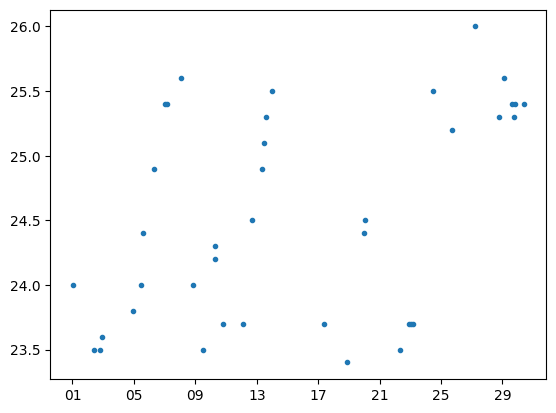

In [93]:
#to filter value_type_id and device_id
filtered_df = readings_df[(readings_df['value_type_id'] == 11) & (readings_df['device_id'] == 1)]

filtered_df.info()

start_date = '2023-8-01'
end_date = '2023-8-31'
filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]

# scatter for >1 day
plt.scatter(filtered_df['date'], filtered_df['value'], marker='.')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))


# scatter for <1 day
# plt.scatter(filtered_df['date'].dt.hour + filtered_df['date'].dt.minute / 60, filtered_df['value'], marker='.')


plt.show



In [94]:
# Augmented Dickey-Fuller test
# determines if a series is stationary
filtered_df.info()

test_series_data = filtered_df[['value']]
test_series_data.index = pd.to_datetime(filtered_df['date'])

results = adfuller(test_series_data)

print('Test Statistic:', results[0])
print('P-Value:', results[1])


<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 52 to 4921
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   device_id      39 non-null     int64         
 1   date           39 non-null     datetime64[ns]
 2   value_type_id  39 non-null     int64         
 3   value          39 non-null     float64       
 4   work_hours     39 non-null     bool          
 5   Fall           39 non-null     bool          
 6   Spring         39 non-null     bool          
 7   Summer         39 non-null     bool          
 8   Winter         39 non-null     bool          
 9   day type       39 non-null     int64         
dtypes: bool(5), datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 KB
Test Statistic: -1.2588939802727803
P-Value: 0.6477624054443933
